In [14]:
import os
import sys
import csv
import json
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [15]:
RED = '\033[31m'
GREEN = '\033[32m'
YELLOW = '\033[33m'
BLUE = '\033[34m'
MAGENTA = '\033[35m'
CYAN = '\033[36m'
WHITE = '\033[37m'
RESET = '\033[0m'

In [16]:
def get_all_subdirectory_names(directory):
    subdirectory_names = []
    # 使用 os.walk 递归遍历目录树
    for root, dirs, files in os.walk(directory):
        for dir_name in dirs:
            print(dir_name)
            subdirectory_names.append(dir_name)
    
    return subdirectory_names

In [17]:
get_all_subdirectory_names(".")

gputime-shortest-consolidate
time-shortest-consolidate
jaca-jaca
fifo-consolidate
smallest-consolidate


['gputime-shortest-consolidate',
 'time-shortest-consolidate',
 'jaca-jaca',
 'fifo-consolidate',
 'smallest-consolidate']

In [18]:
def get_scale_factor(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
        
    for line in lines:
        if "sf =" in line:
            sf = int(line.split("=")[1].strip())
            return sf

In [19]:
def extract_info(s:str)->dict:
    info = dict()
    time_pattern = re.compile(r'Time\[(\d+\.\d+)ms\]')
    id_pattern = re.compile(r'Job\[\s*(\d+)\]')


    info["job_id"] = int(re.findall("\[(.*?)\]",s,re.I|re.M)[1])
    info["time"] = float(re.findall("\[(.*?)\]",s,re.I|re.M)[0].split()[0])
    info["event"] = s.split(",")[1].strip()

    return info

In [20]:
def get_job_num(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    
    lines = [extract_info(line) for line in lines if line.startswith("DEBUG")]
    return int(len(lines) / 3) , lines

In [21]:
def get_job_event_time(job_id:int,event:str,lines:list,scale_factor):
    for line in lines:
        if line["job_id"] == job_id and line["event"] == event:
            return float(line["time"]) * scale_factor / 1000
    return None

In [22]:
def main(sched_name:str, scale_factor):
    filename = os.path.join(sched_name, "res.csv")
    job_num, lines = get_job_num(filename)
    #print(lines)
    jobs = dict()
    jct_sum = list()
    exec_time_list = list()
    for job_id in range(job_num):
        arrive_time = get_job_event_time(job_id,"ARRIVE",lines,scale_factor)
        #print(arrive_time) 
        place_time  = get_job_event_time(job_id,"START", lines,scale_factor)
        end_time    = get_job_event_time(job_id,"END",   lines,scale_factor)
        jobs[job_id] = {
            "arrive_time":arrive_time,
            "place_time":place_time,
            "end_time":end_time,
            "pend_time":place_time - arrive_time,
            "exec_time":end_time - place_time
        }
        #print(job_id,"%.2f" % (end_time - arrive_time))
        jct_sum.append(end_time - arrive_time)
        exec_time_list.append(float("%.2f" % (end_time - arrive_time)))
        ave_jct = np.mean(np.array((jct_sum)))
    tmp = [float("%.2f" % i) for i in jct_sum]
    # print("JCT", tmp)
    # print("EXEC", exec_time_list)
    print("*" * 40)
    print(f"{YELLOW}Schedule name: %s{RESET}" % sched_name)
    print(f"{GREEN}Ave JCT: %.2f{RESET}" % (sum(jct_sum) / job_num))
    print(f"{GREEN}95%%-th JCT: %.2f{RESET}" % np.percentile(jct_sum, 95))
    print(f"{GREEN}Makespan: %.2f{RESET}" % (float(lines[-1]["time"] - lines[0]["time"]) * scale_factor / 1000))
    return jobs, sum(jct_sum) / job_num, np.percentile(jct_sum, 95), (lines[-1]["time"] - lines[0]["time"])

In [23]:
def prefix_sum(lst, loc):
    sum = 0
    for i in range(len(lst)):
        if i < loc:
            sum += lst[i]
    return sum

In [24]:
def make_tiny_bar_config(dirname, job_num, place_list, scale_factor):
    bar_list = list()
    
    tput_file = os.listdir(dirname)
    
    tput_file = [os.path.join(dirname, filename) for filename in tput_file if filename.split(".")[-1] == "txt" and int(filename.split("-")[1]) in list(range(job_num))]
   
    for file in tput_file:
        with open(file, "r") as f:
            job_id = int(file.split("-")[-2])
            lines = f.readlines()
            tput_list = list()
            height_list = list()
            for line in lines:
                tput_list.append(float(line.split(",")[1]) * scale_factor / 1000)
            for i,line in enumerate(lines):
                bottom = place_list[job_id] + prefix_sum(tput_list, i)
                height = tput_list[i] 
                if max(tput_list) == min(tput_list):
                    color = plt.cm.viridis(1 - (height - min(tput_list)) / min(tput_list))
                else:
                    color = plt.cm.viridis(1 - (height - min(tput_list)) / (max(tput_list) - min(tput_list)))

                bar_list.append({
                    "job_id": job_id,
                    "bottom": bottom,
                    "height":height,
                    "color": color
                })
    return bar_list

gputime-shortest-consolidate
time-shortest-consolidate
jaca-jaca
fifo-consolidate
smallest-consolidate
['gputime-shortest-consolidate', 'time-shortest-consolidate', 'jaca-jaca', 'fifo-consolidate', 'smallest-consolidate']
****************************************
Schedule name: gputime-shortest-consolidate
Ave JCT: 820.94
95%-th JCT: 2900.69
Makespan: 6541.65
****************************************
Schedule name: time-shortest-consolidate
Ave JCT: 1045.80
95%-th JCT: 3451.21
Makespan: 6943.49
****************************************
Schedule name: jaca-jaca
Ave JCT: 931.89
95%-th JCT: 3146.73
Makespan: 5951.80
****************************************
Schedule name: fifo-consolidate
Ave JCT: 1724.45
95%-th JCT: 4242.26
Makespan: 7473.36
****************************************
Schedule name: smallest-consolidate
Ave JCT: 1418.47
95%-th JCT: 4757.00
Makespan: 9016.16


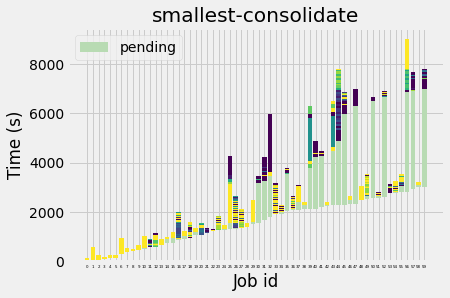

In [25]:
sched_list = get_all_subdirectory_names(".")

sched_dict = {i:v for i,v in enumerate(sched_list)}
#sched_list = [sched_list[0]]
print(sched_list)

jct_dict = dict()
jct_dict_95 = dict()
makespan_list = dict()
scale_factor = get_scale_factor("../../run.py")
for sched in sched_list:
    jobs_info, ave_jct, jct_95, makespan = main(sched,scale_factor)
    jct_dict[sched] = ave_jct
    jct_dict_95[sched] = jct_95
    makespan_list[sched] = makespan
    #continue
    arrive_list = [v["arrive_time"] for k,v in jobs_info.items()]
    pend_list   = [v["pend_time"]   for k,v in jobs_info.items()]
    exec_list   = [v["exec_time"]   for k,v in jobs_info.items()]
    place_list  = [v["place_time"]  for k,v in jobs_info.items()]
    plt.cla()
    plt.style.use("fivethirtyeight")
    plt.bar(range(len(jobs_info)), pend_list, bottom=arrive_list, color = "#B8DBB3", label = "pending")
    bar_list = make_tiny_bar_config(sched, len(arrive_list), place_list, scale_factor)
    # plt.bar(range(len(jobs_info)), exec_list, bottom=place_list,  color = "#E29135", label = "running")\
    for bar in bar_list:
        plt.bar([bar["job_id"]],[bar["height"]],bottom=[bar["bottom"]],color = bar["color"])
    
    #plt.text(7, 20000, "the deeper color, the slower", fontsize=12, color='red')
    plt.title(sched)
    plt.xticks(range(len(jobs_info)), fontsize=4)
    plt.xlabel("Job id")
    plt.ylabel("Time (s)")
    plt.legend()
    plt.savefig("%s/res.pdf" % sched, bbox_inches = "tight")

{0: 'GT-C', 1: 'Time-C', 2: 'jaca', 3: 'Arr-C', 4: 'GPU-C'}


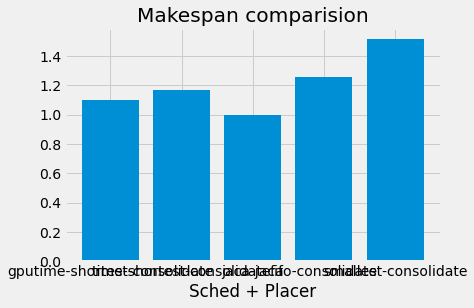

In [26]:
def write_res(filename, xlabel_dict, res_list):
    with open(filename, "w") as f:
        for sched_name, v in zip(list(xlabel_dict.values()), res_list):
            f.write(f"{sched_name},{v}\n")
xlabel_dict = {
    "smallest-load_balance":"GPU-LB",
    "gputime-shortest-consolidate":"GT-C",
    "fifo-load_balance":"Arr-LB",
    "time-shortest-consolidate":"Time-C",
    "gputime-shortest-load_balance":"GT-LB",
    "fifo-consolidate":"Arr-C", 
    "time-shortest-load_balance":"Time-LB",
    "smallest-consolidate":"GPU-C",
    "jaca-jaca":"jaca"
}
xlabel_dict = {i:xlabel_dict[v] for i,v in enumerate(sched_list)}
print(xlabel_dict)
# JCT
plt.cla()
plt.title("JCT comparision")
plt.style.use("fivethirtyeight")

uniform_value = np.array(list(jct_dict.values())) / min(jct_dict.values())
plt.bar(range(len(jct_dict)), uniform_value)
plt.xlabel("Sched + Placer")
plt.xticks(list(xlabel_dict.keys()),list(xlabel_dict.values()),rotation = 0, fontsize = 14)

write_res("jct.csv", xlabel_dict, uniform_value)

plt.savefig("jct.pdf", bbox_inches = "tight")

# 95th JCT
plt.cla()
plt.title("JCT-95th comparision")
plt.style.use("fivethirtyeight")

uniform_value = np.array(list(jct_dict_95.values())) / min(jct_dict_95.values())
plt.bar(range(len(jct_dict_95)),uniform_value)
plt.xlabel("Sched + Placer")
plt.xticks(range(len(jct_dict_95)),sched_list,rotation = 0, fontsize = 14)
write_res("jct-95th.csv", xlabel_dict, uniform_value)
plt.savefig("jct-95th.pdf", bbox_inches = "tight")

# Makespan
plt.cla()
plt.title("Makespan comparision")
plt.style.use("fivethirtyeight")

uniform_value = np.array(list(makespan_list.values())) / min(makespan_list.values())
plt.bar(range(len(makespan_list)),uniform_value)
plt.xlabel("Sched + Placer")
plt.xticks(range(len(makespan_list)),sched_list,rotation = 0, fontsize = 14)

write_res("makespan.csv", xlabel_dict, uniform_value)
plt.savefig("makespan.pdf", bbox_inches = "tight")